In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import rerun as rr
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    MeshRenderer, MeshRasterizer, FoVPerspectiveCameras,
    RasterizationSettings, look_at_view_transform,
    PointLights
)

import rerun_util as ru

In [ ]:
from pytorch3d.structures import Meshes

device = torch.device("cuda:0")
meshes: Meshes = load_objs_as_meshes(['data/max-planck.obj'], device=device)

In [3]:
from pytorch3d.renderer import HardPhongShader, SoftSilhouetteShader

torch.no_grad()

# lights
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# cameras
dist = 300
azim = 150
elev = 0
R, T = look_at_view_transform(dist=dist, azim=azim, elev=elev)

cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60)

ru.pt3d_FovCamera(cameras)

# raster settings
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
shader = SoftSilhouetteShader()

renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

renders = renderer(meshes, cameras=cameras)
fragments = rasterizer(meshes)

render = renders.cpu()
depth = fragments.zbuf.cpu()

torch.Size([1, 512, 512, 4])
torch.Size([1, 512, 512, 1])


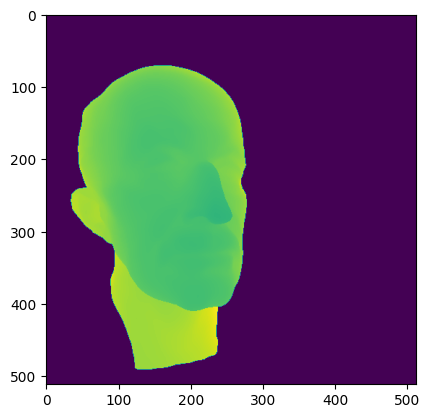

In [4]:
import matplotlib.pyplot as plt

torch.save(depth, 'data/depth.pt')
torch.save(render, 'data/render.pt')

print(render.shape)
print(depth.shape)

plt.imshow(render[0])
plt.imshow(depth[0])

In [2]:

# VISUALIZATION:
rr.init(spawn=True, application_id='meshvis')

rr.log('/', rr.ViewCoordinates.LUF, static=True)
rr.log('/', rr.Transform3D())

# log mesh
rr.log("mesh", ru.pt3d_mesh(meshes))

# log camera
rr.log('cam', ru.pt3d_FovCamera(cameras, res=100))
cam_trans = cameras.get_world_to_view_transform().inverse()
rr.log('cam', ru.pt3d_transform(cam_trans))

print(depth.shape)
# log depth
rr.log('cam', rr.Image(depth[0].numpy()))

NameError: name 'rr' is not defined